# A simple simulator for Stratified media under normal incidence

## Imports

In [1]:
import jax
import jax.numpy as jnp
import numpy as onp
import matplotlib.pyplot as plt
from scipy.constants import epsilon_0, c as c0

In [2]:
import sax
import meow
import meow.eme.propagate
from sax.backends import circuit_backends
from sax.saxtypes import scoo
sax_backend = meow.eme.sax._validate_sax_backend("klu")

## Layer Stack

In [3]:
ns = [2, 1.889+0.0035j, 1.802+0.0562j, 2.321+0.291j, 1.519+0.0043j]
ds = [1, 0.15, 0.03, 0.3, 0.2]
# ns = [2]
# ds = [0.3]
wl = 1
xi = jnp.cumsum(jnp.array(ds))

## Fresnel and Propagation

In [4]:
def fresnel_mirror_ij(ni=1.0, nj=1.0):
    """Model a (fresnel) interface between twoo refractive indices

    Args:
        ni: refractive index of the initial medium
        nf: refractive index of the final
    """
    r_fresnel_ij = (ni - nj) / (ni + nj)  # i->j reflection
    t_fresnel_ij = 2 * ni / (ni + nj)  # i->j transmission
    r_fresnel_ji = -r_fresnel_ij  # j -> i reflection
    t_fresnel_ji = (1 - r_fresnel_ij**2) / t_fresnel_ij  # j -> i transmission 2 * nj / (ni + nj)#
    sdict = {
        ("left", "left"): r_fresnel_ij,
        ("left", "right"): t_fresnel_ij,
        ("right", "left"): t_fresnel_ji,
        ("right", "right"): r_fresnel_ji,
    }
    return sdict


def propagation_i(ni=1.0, di=0.5, wl=wl):
    """Model the phase shift acquired as a wave propagates through medium A

    Args:
        ni: refractive index of medium (at wavelength wl)
        di: [μm] thickness of layer
        wl: [μm] wavelength
    """
    prop_i = jnp.exp(1j * 2 * jnp.pi * ni * di / wl)
    sdict = {
        ("left", "right"): prop_i,
        ("right", "left"): prop_i,
    }
    return sdict

In [5]:
fresnel_mirror_ij(ni=1.0, nj=2)

{('left', 'left'): -0.3333333333333333,
 ('left', 'right'): 0.6666666666666666,
 ('right', 'left'): 1.3333333333333333,
 ('right', 'right'): 0.3333333333333333}

## Layers
let's set up the sax components for the different layers

In [6]:
identity = fresnel_mirror_ij(1, 1)

In [7]:
propagations=[propagation_i(ni, di) for ni, di in zip(ns, ds)]
propagations=[identity]+propagations+[identity]
propagations = {f"p_{i}": sax.sdense(p) for i, p in enumerate(propagations)}

In [8]:
padded_ns = [1]+ns+[1]
interfaces=[fresnel_mirror_ij(ni, nj) for ni, nj in zip(padded_ns, padded_ns[1:])]
#interfaces=[identity]+interfaces+[identity]
interfaces = {f"i_{i}_{i+1}": sax.sdense(p) for i, p in enumerate(interfaces)}

## Propagate Interface Pairs 
Combine successive propagation sections and interfaces into Propagate Interface Pairs (pi_pairs).

In [9]:
pairs = meow.eme.propagate.pi_pairs(propagations, interfaces, sax_backend)

## Accumulate
Split the whole device into left and right sections with the split moving from left to right

In [10]:
l2rs = meow.eme.propagate.l2r_matrices(pairs, identity, sax_backend)
r2ls = meow.eme.propagate.r2l_matrices(pairs, sax_backend)

## Excite from the left

In [11]:
ex_l = jnp.array([1])
ex_r = jnp.array([0])

## Calculate Amplitudes
TODO: explain how it works

In [12]:
l2rs

[{('left', 'left'): 0.0,
  ('left', 'right'): 1.0,
  ('right', 'left'): 1.0,
  ('right', 'right'): -0.0},
 (Array([[-0.33333333+0.j,  0.66666667+0.j],
         [ 1.33333333+0.j,  0.33333333+0.j]], dtype=complex128),
  {'left': 0, 'right': 1}),
 (Array([[-0.30771995-0.00083869j,  0.69228005-0.00083869j],
         [ 1.30771995+0.00083869j,  0.30771995+0.00083869j]],      dtype=complex128),
  {'left': 0, 'right': 1}),
 (Array([[-0.33205182+0.0026183j , -0.13581737+0.68703481j],
         [-0.28335426+1.23040378j, -0.2996087 -0.10993471j]],      dtype=complex128),
  {'left': 0, 'right': 1}),
 (Array([[-0.32166488+0.12226765j, -0.30473294+0.5267063j ],
         [-0.86055669+1.13380805j, -0.02153198-0.22482351j]],      dtype=complex128),
  {'left': 0, 'right': 1}),
 (Array([[-0.27584913+0.16761167j,  0.41715351+0.10642717j],
         [ 0.63319855+0.16345664j, -0.16203636-0.00655842j]],      dtype=complex128),
  {'left': 0, 'right': 1}),
 (Array([[-0.29675419+0.11262296j, -0.30388136+0.4335105

In [13]:
r2ls

[(Array([[-0.29675419+0.11262296j, -0.30388136+0.43351056j],
         [-0.30388136+0.43351056j, -0.08956886+0.10464134j]],      dtype=complex128),
  {'left': 0, 'right': 1}),
 (Array([[ 0.04572253+0.12308147j, -0.42219637+0.65905633j],
         [-0.21109818+0.32952816j, -0.05021629+0.20046672j]],      dtype=complex128),
  {'left': 0, 'right': 1}),
 (Array([[ 0.01677393+0.12424164j, -0.41356207+0.63932711j],
         [-0.21830391+0.33885186j, -0.05410692+0.19261899j]],      dtype=complex128),
  {'left': 0, 'right': 1}),
 (Array([[-0.08951175-0.09228936j,  0.69133676+0.2746098j ],
         [ 0.38802501+0.14029012j, -0.04573579+0.19401348j]],      dtype=complex128),
  {'left': 0, 'right': 1}),
 (Array([[-0.00086129+0.03061557j,  0.86071608+0.07536907j],
         [ 0.36910765-0.01380493j, -0.08623208+0.17714298j]],      dtype=complex128),
  {'left': 0, 'right': 1}),
 (Array([[-0.15814967-0.12858383j, -0.39907938+1.13120594j],
         [-0.26061486+0.74544212j, -0.20603645-0.00135532j]],   

In [14]:
forwards, backwards = meow.eme.propagate.propagate(l2rs, r2ls, ex_l, ex_r)

In [15]:
forwards

[Array([1.+0.j], dtype=complex128),
 Array([1.35162291+0.05631148j], dtype=complex128),
 Array([1.31239567+0.05129159j], dtype=complex128),
 Array([-0.33537791+1.23847886j], dtype=complex128),
 Array([-0.8660018+1.14209356j], dtype=complex128),
 Array([0.64520592+0.18208135j], dtype=complex128),
 Array([-0.30388136+0.43351056j], dtype=complex128)]

In [16]:
backwards

[Array([-0.29675419+0.11262296j], dtype=complex128),
 Array([0.05486872+0.16893444j], dtype=complex128),
 Array([0.01564149+0.16391455j], dtype=complex128),
 Array([0.14431869-0.0799066j], dtype=complex128),
 Array([-0.03421996-0.02749681j], dtype=complex128),
 Array([-0.07862639-0.11175916j], dtype=complex128),
 Array([0.+0.j], dtype=complex128)]

In [17]:
def fields(padded_ns, xi, forwards, backwards, x):
    """Calculates the fields within a stack at given positions x
    Attention xi > 0
    """
    xi = onp.concatenate([[-onp.inf, 0], xi, [onp.inf]])
    E_tot = onp.zeros((len(x),), dtype=complex)
    Abs_tot = onp.zeros((len(x),), dtype=complex)
    for n, forward, backward, x_min, x_max in zip(padded_ns, forwards, backwards, xi, xi[1:]):
        has_contribution = onp.any(onp.logical_and(x > x_min, x < x_max))
        if not has_contribution:
            continue
        #print(f"{n}: {x_min} - {x_max}: -> {forward[0]}; <- {backward[0]}")
        i_min = onp.argmax(x >= x_min)
        i_max = onp.argmax(x > x_max)
        
        if i_max == 0:
            x_ = x[i_min:]
        else:
            x_ = x[i_min:i_max]

        if onp.isinf(x_min):
            x_local = x_
        else:
            x_local = x_ - x_min
        E_local = forward*onp.exp(2j * onp.pi * n / wl * x_local)
        E_local -= backward*onp.exp(-2j * onp.pi * n / wl * x_local)

        if i_max == 0:
            E_tot[i_min:] = E_local
        else:
            E_tot[i_min:i_max] = E_local

        eps = n**2 * epsilon_0
        omega = 2 * onp.pi * c0/wl
        Abs_local = 0.5* omega * eps.imag * onp.abs(E_local)**2
        if i_max == 0:
            Abs_tot[i_min:] = Abs_local
        else:
            Abs_tot[i_min:i_max] = Abs_local
            
    return E_tot, Abs_tot

In [21]:
x = jnp.linspace(-1, 2, 400)
field, absorption = fields(padded_ns, xi, forwards, backwards, x)

Text(0, 0.5, '$|E(x)|$')

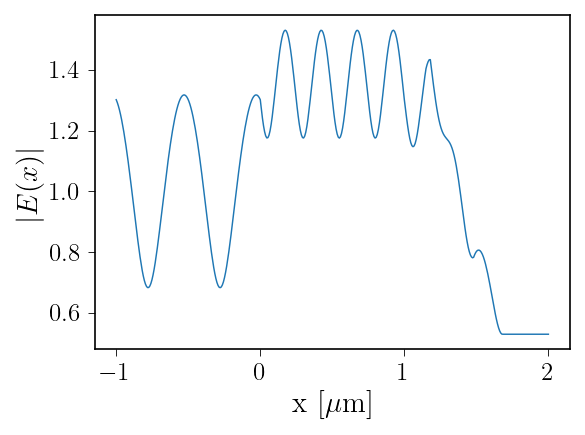

In [22]:
plt.plot(x, onp.abs(field))
#plt.axhline(1, color="k", linestyle="--")
#plt.ylim((0, None))
plt.xlabel("x [$\mu$m]")
plt.ylabel("$|E(x)|$")

Text(0, 0.5, 'Absorption')

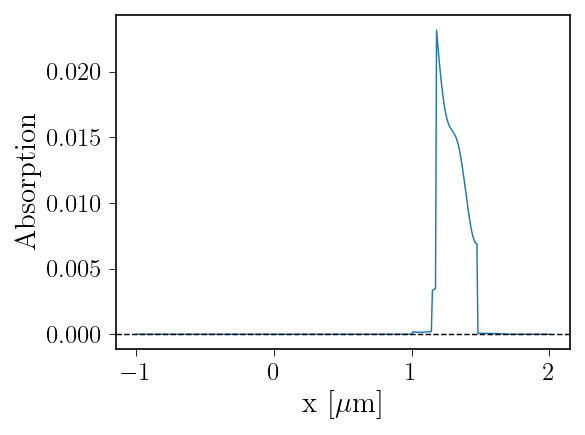

In [24]:
plt.plot(x, absorption)
plt.axhline(0, color="k", linestyle="--")
plt.xlabel("x [$\mu$m]")
plt.ylabel("Absorption")

